# Apply TabM code from Author(Github)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset
import random
from tabm_reference import Model, make_parameter_groups
import torch.nn as nn
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score

random.seed ( 12 )


df = pd.read_csv('diabetes.csv')
X = df.drop('Outcome', axis=1).values
y = df['Outcome'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# torch tensor
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                              torch.tensor(y_train, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                             torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [17]:

# TabM 
tabm_model = Model(
    n_num_features=8,
    cat_cardinalities=[],
    n_classes=2,
    backbone={'type':'MLP','n_blocks':2,'d_block':64,'dropout':0.1},
    bins=None,
    arch_type='tabm',
    k=8,
)

# TabM-mini 
tabm_mini_model = Model(
    n_num_features=8,
    cat_cardinalities=[],
    n_classes=2,
    backbone={'type':'MLP','n_blocks':2,'d_block':64,'dropout':0.1},
    bins=None,
    arch_type='tabm-mini',
    k=8,
)

# MLP
class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(8,64), nn.ReLU(), nn.Linear(64,2))
        
    def forward(self,x):
        return self.model(x)

mlp_model = SimpleMLP()

# XGBoost
xgb_model = xgb.XGBClassifier(eval_metric='logloss')


In [18]:
def train_model(model, loader, epochs=30):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for X_batch, y_batch in loader:
            preds = model(X_batch).mean(dim=1) if isinstance(model, Model) else model(X_batch)
            loss = criterion(preds, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {epoch_loss:.4f}")



In [19]:
print("Training TabM:")
train_model(tabm_model, train_loader)

print("\nTraining TabM-mini:")
train_model(tabm_mini_model, train_loader)

print("\nTraining MLP:")
train_model(mlp_model, train_loader)

print("\nTraining XGBoost:")
xgb_model.fit(X_train, y_train)



Training TabM:
Epoch [1/30] - Loss: 12.9480
Epoch [2/30] - Loss: 11.6151
Epoch [3/30] - Loss: 10.3163
Epoch [4/30] - Loss: 9.5727
Epoch [5/30] - Loss: 9.4879
Epoch [6/30] - Loss: 9.3146
Epoch [7/30] - Loss: 8.9437
Epoch [8/30] - Loss: 8.9472
Epoch [9/30] - Loss: 9.2505
Epoch [10/30] - Loss: 9.1694
Epoch [11/30] - Loss: 8.8003
Epoch [12/30] - Loss: 8.5752
Epoch [13/30] - Loss: 8.6043
Epoch [14/30] - Loss: 9.2029
Epoch [15/30] - Loss: 8.5955
Epoch [16/30] - Loss: 8.6603
Epoch [17/30] - Loss: 8.4271
Epoch [18/30] - Loss: 8.8911
Epoch [19/30] - Loss: 8.8977
Epoch [20/30] - Loss: 8.3153
Epoch [21/30] - Loss: 8.3950
Epoch [22/30] - Loss: 8.5850
Epoch [23/30] - Loss: 8.4158
Epoch [24/30] - Loss: 8.3453
Epoch [25/30] - Loss: 8.2037
Epoch [26/30] - Loss: 8.3466
Epoch [27/30] - Loss: 8.4628
Epoch [28/30] - Loss: 8.1038
Epoch [29/30] - Loss: 8.2482
Epoch [30/30] - Loss: 8.4277

Training TabM-mini:
Epoch [1/30] - Loss: 13.2699
Epoch [2/30] - Loss: 11.8966
Epoch [3/30] - Loss: 10.6824
Epoch [4/30] 

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [20]:
def evaluate_model(model, loader):
    model.eval()
    preds_list, true_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            preds = model(X_batch).mean(dim=1) if isinstance(model, Model) else model(X_batch)
            probs = torch.softmax(preds, dim=1)[:,1]
            preds_list.extend(probs.numpy())
            true_labels.extend(y_batch.numpy())
    acc = accuracy_score(true_labels, np.array(preds_list)>0.5)
    auc_score = roc_auc_score(true_labels, preds_list)
    return acc, auc_score, preds_list


In [21]:

tabm_acc, tabm_auc, tabm_probs = evaluate_model(tabm_model, test_loader)
mini_acc, mini_auc, mini_probs = evaluate_model(tabm_mini_model, test_loader)
mlp_acc, mlp_auc, mlp_probs = evaluate_model(mlp_model, test_loader)
xgb_probs = xgb_model.predict_proba(X_test)[:,1]
xgb_acc = accuracy_score(y_test, xgb_probs>0.5)
xgb_auc = roc_auc_score(y_test, xgb_probs)

print(f"TabM Accuracy: {tabm_acc:.4f}, AUC: {tabm_auc:.4f}")
print(f"TabM-mini Accuracy: {mini_acc:.4f}, AUC: {mini_auc:.4f}")
print(f"MLP Accuracy: {mlp_acc:.4f}, AUC: {mlp_auc:.4f}")
print(f"XGB Accuracy: {xgb_acc:.4f}, AUC: {xgb_auc:.4f}")


TabM Accuracy: 0.7273, AUC: 0.8169
TabM-mini Accuracy: 0.7338, AUC: 0.8191
MLP Accuracy: 0.7273, AUC: 0.8276
XGB Accuracy: 0.7338, AUC: 0.8052


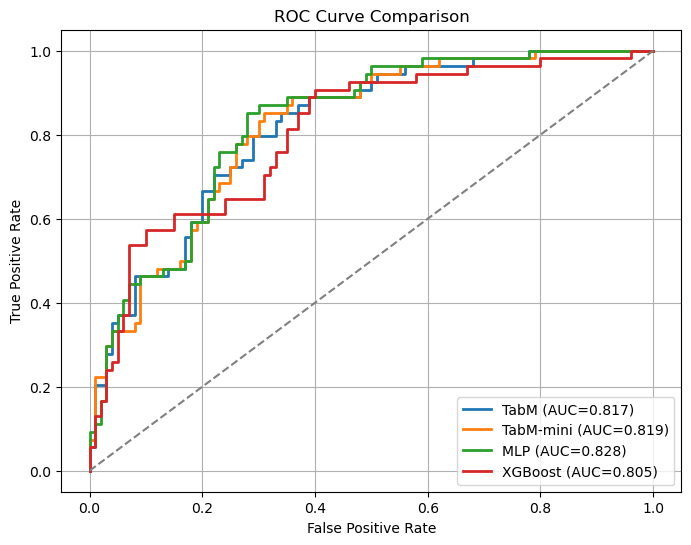

In [22]:

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8, 6))

def plot_roc(y_true, probs, label):
    fpr, tpr, _ = roc_curve(y_true, probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{label} (AUC={roc_auc:.3f})')

plot_roc(y_test, tabm_probs, 'TabM')
plot_roc(y_test, mini_probs, 'TabM-mini')
plot_roc(y_test, mlp_probs, 'MLP')
plot_roc(y_test, xgb_probs, 'XGBoost')


plt.plot([0, 1], [0, 1], '--', color='gray')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid()
plt.show()



# Write TabM code from scratch

In [23]:
class TabMLayer(nn.Module):
    def __init__(self, input_dim, output_dim, num_models=8):
        super().__init__()
        self.num_models = num_models
        self.linear = nn.Linear(input_dim, output_dim, bias=False)
        self.r = nn.Parameter(torch.randn(num_models, input_dim))
        self.s = nn.Parameter(torch.randn(num_models, output_dim))
        self.b = nn.Parameter(torch.zeros(num_models, output_dim))

    def forward(self, x):
    
        outputs = []
        for i in range(self.num_models):
            x_mod = x * self.r[i]  
            out = self.linear(x_mod)  
            out = out * self.s[i] + self.b[i]  
            outputs.append(out)

        return torch.stack(outputs).mean(dim=0)


In [24]:
class TabMModel(nn.Module):
    def __init__(self, input_dim=8, hidden_dim=64, output_dim=2, num_models=8):
        super().__init__()
        self.layer1 = TabMLayer(input_dim, hidden_dim, num_models)
        self.relu = nn.ReLU()
        self.layer2 = TabMLayer(hidden_dim, output_dim, num_models)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.layer2(x)
        return x


In [25]:
class TabMminiModel(nn.Module):
    def __init__(self, input_dim=8, hidden_dim=64, output_dim=2, num_models=8):
        super().__init__()
        self.layer1 = TabMLayer(input_dim, hidden_dim, num_models)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.layer2(x)
        return x


In [26]:
class SimpleMLP(nn.Module):
    def __init__(self, input_dim=8, hidden_dim=64, output_dim=2):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.layers(x)


In [27]:
def train_model(model, loader, epochs=30):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for X_batch, y_batch in loader:
            preds = model(X_batch)
            loss = criterion(preds, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {epoch_loss:.4f}")


In [28]:

tabm_model = TabMModel()
tabm_mini_model = TabMminiModel()
mlp_model = SimpleMLP()

# TabM 
print("Training TabM:")
train_model(tabm_model, train_loader)

# TabM-mini
print("\nTraining TabM-mini:")
train_model(tabm_mini_model, train_loader)

# MLP 
print("\nTraining MLP:")
train_model(mlp_model, train_loader)

# XGBoost 
print("\nTraining XGBoost:")
xgb_model = xgb.XGBClassifier(eval_metric='logloss')
xgb_model.fit(X_train, y_train)


Training TabM:
Epoch [1/30] - Loss: 13.8473
Epoch [2/30] - Loss: 13.5153
Epoch [3/30] - Loss: 13.1339
Epoch [4/30] - Loss: 12.6775
Epoch [5/30] - Loss: 12.1372
Epoch [6/30] - Loss: 11.3468
Epoch [7/30] - Loss: 10.9390
Epoch [8/30] - Loss: 10.2373
Epoch [9/30] - Loss: 9.9650
Epoch [10/30] - Loss: 9.5824
Epoch [11/30] - Loss: 9.4527
Epoch [12/30] - Loss: 9.4480
Epoch [13/30] - Loss: 9.5272
Epoch [14/30] - Loss: 9.0328
Epoch [15/30] - Loss: 9.1872
Epoch [16/30] - Loss: 9.2240
Epoch [17/30] - Loss: 9.2996
Epoch [18/30] - Loss: 8.9681
Epoch [19/30] - Loss: 9.2833
Epoch [20/30] - Loss: 8.9088
Epoch [21/30] - Loss: 9.1585
Epoch [22/30] - Loss: 9.1119
Epoch [23/30] - Loss: 9.2848
Epoch [24/30] - Loss: 8.6628
Epoch [25/30] - Loss: 9.0356
Epoch [26/30] - Loss: 9.0692
Epoch [27/30] - Loss: 8.9144
Epoch [28/30] - Loss: 8.7321
Epoch [29/30] - Loss: 8.8276
Epoch [30/30] - Loss: 9.0092

Training TabM-mini:
Epoch [1/30] - Loss: 12.9794
Epoch [2/30] - Loss: 12.2877
Epoch [3/30] - Loss: 11.7334
Epoch [4

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [29]:
def evaluate_model(model, loader):
    model.eval()
    preds_list, true_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            preds = model(X_batch)
            probs = torch.softmax(preds, dim=1)[:, 1]
            preds_list.extend(probs.numpy())
            true_labels.extend(y_batch.numpy())
    accuracy = accuracy_score(true_labels, np.array(preds_list) > 0.5)
    auc = roc_auc_score(true_labels, preds_list)
    return accuracy, auc


In [30]:
# TabM
tabm_acc, tabm_auc = evaluate_model(tabm_model, test_loader)
print(f'TabM Accuracy: {tabm_acc:.4f}, AUC: {tabm_auc:.4f}')

# TabM-mini
mini_acc, mini_auc = evaluate_model(tabm_mini_model, test_loader)
print(f'TabM-mini Accuracy: {mini_acc:.4f}, AUC: {mini_auc:.4f}')

# MLP
mlp_acc, mlp_auc = evaluate_model(mlp_model, test_loader)
print(f'MLP Accuracy: {mlp_acc:.4f}, AUC: {mlp_auc:.4f}')

# XGBoost
xgb_preds = xgb_model.predict_proba(X_test)[:,1]
xgb_acc = accuracy_score(y_test, xgb_preds > 0.5)
xgb_auc = roc_auc_score(y_test, xgb_preds)
print(f'XGBoost Accuracy: {xgb_acc:.4f}, AUC: {xgb_auc:.4f}')


TabM Accuracy: 0.7273, AUC: 0.8224
TabM-mini Accuracy: 0.7273, AUC: 0.8291
MLP Accuracy: 0.7468, AUC: 0.8248
XGBoost Accuracy: 0.7338, AUC: 0.8052


# Evaluate TabM model with Three Datasets

In [ ]:
import os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

#  TabM 
from tabm_reference import Model


DATA_DIR = ''
DATASETS = {
    'Diabetes': {
        'path': os.path.join(DATA_DIR, 'diabetes.csv'),
        'target': 'Outcome',
        'binarize': None,
    },
    'HeartDisease': {
        'path': os.path.join(DATA_DIR, 'heart.csv'),
        'target': 'num',
        'binarize': lambda y: (y > 0).astype(int),
    },
    'WineQuality': {
        'path': os.path.join(DATA_DIR, 'winequality-red.csv'),
        'target': 'quality',
        'binarize': lambda y: (y >= 7).astype(int),
    },
}

SEEDS      = list(range(1,31))
TEST_SIZE  = 0.2
BATCH_SIZE = 64
EPOCHS     = 20
LR         = 1e-3


def load_and_preprocess(path, target_col, binarize_fn=None):

    df = pd.read_csv(path)


    df.replace('?', np.nan, inplace=True)


    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()


    for c in num_cols:
        median = df[c].median()
        df[c].fillna(median, inplace=True)

    for c in cat_cols:
        df[c].fillna('missing', inplace=True)

    
    y = df[target_col].values
    if binarize_fn is not None:
        y = binarize_fn(y)
    y = y.astype(int)

    X_df = df.drop(columns=[target_col])


    cat_cols = X_df.select_dtypes(include=['object', 'category']).columns.tolist()
    if cat_cols:
        X_df = pd.get_dummies(X_df, columns=cat_cols, drop_first=True)

    #  numpy
    X = X_df.values.astype(float)
    return X, y, X.shape[1]


def prepare_split(X, y, seed):
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=TEST_SIZE, stratify=y, random_state=seed
    )
    scaler = StandardScaler().fit(X_tr)
    return scaler.transform(X_tr), scaler.transform(X_te), y_tr, y_te


def run_mlp_once(X_tr, y_tr, X_te, y_te, seed):
    """
    使用更温和的学习率、自适应学习率和早停策略，
    并将最大迭代步数调到 500，以缓解 ConvergenceWarning。
    """
    clf = MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        solver='adam',
        learning_rate='adaptive',
        learning_rate_init=1e-4,
        early_stopping=True,
        n_iter_no_change=10,
        max_iter=800,
        random_state=seed,
        verbose=False 
    )
    clf.fit(X_tr, y_tr)
    preds = clf.predict(X_te)
    return accuracy_score(y_te, preds)


def run_tabm_once(X_tr, y_tr, X_te, y_te, seed, feat_dim):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    model = Model(
        n_num_features=feat_dim,
        cat_cardinalities=[],
        n_classes=len(np.unique(y_tr)),
        backbone={'type':'MLP','n_blocks':2,'d_block':64,'dropout':0.1},
        arch_type='tabm', k=8,
        bins=None, num_embeddings=None,
        share_training_batches=True
    ).to(device)

    opt = torch.optim.Adam(model.parameters(), lr=LR)
    loss_fn = nn.CrossEntropyLoss()

    tr_ds = TensorDataset(torch.from_numpy(X_tr).float(),
                          torch.from_numpy(y_tr).long())
    te_ds = TensorDataset(torch.from_numpy(X_te).float(),
                          torch.from_numpy(y_te).long())
    tr_loader = DataLoader(tr_ds, batch_size=BATCH_SIZE, shuffle=True)
    te_loader = DataLoader(te_ds, batch_size=BATCH_SIZE, shuffle=False)

    model.train()
    for _ in range(EPOCHS):
        for xb, yb in tr_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            out = model(x_num=xb).mean(dim=1)
            loss_fn(out, yb).backward()
            opt.step()

    model.eval()
    all_p, all_t = [], []
    with torch.no_grad():
        for xb, yb in te_loader:
            xb = xb.to(device)
            out = model(x_num=xb).mean(dim=1)
            preds = out.argmax(dim=1).cpu().numpy()
            all_p.append(preds); all_t.append(yb.numpy())

    return accuracy_score(np.concatenate(all_t),
                          np.concatenate(all_p))


def plot_results(runs, mlp_accs, tabm_accs, name):
    m_mean, m_std = mlp_accs.mean(), mlp_accs.std()
    t_mean, t_std = tabm_accs.mean(), tabm_accs.std()


    plt.figure(figsize=(6,4))
    plt.plot(runs, mlp_accs, '-o', label='MLP')
    plt.plot(runs, tabm_accs, '-s', label='TabM')
    plt.title(f'{name} – per seed')
    plt.xlabel('Seed'); plt.ylabel('Accuracy')
    plt.ylim(0,1); plt.xticks(runs)
    plt.grid(True); plt.legend(); plt.tight_layout()
    plt.savefig(f'{name}_line.png', dpi=300); plt.close()


    plt.figure(figsize=(4,4))
    plt.bar(['MLP','TabM'], [m_mean,t_mean],
            yerr=[m_std,t_std], capsize=8)
    plt.title(f'{name} – mean±std'); plt.ylim(0,1)
    plt.tight_layout(); plt.savefig(f'{name}_bar.png', dpi=300)
    plt.close()

# -----------------------------
# main
# -----------------------------
if __name__ == '__main__':
    for name, cfg in DATASETS.items():
        print(f'\n▶ Running {name}')
        X, y, dim = load_and_preprocess(cfg['path'],
                                        cfg['target'],
                                        cfg['binarize'])
        print(f'  feature dim={dim}, positive ratio={y.mean():.2f}')

        mlp_scores, tabm_scores = [], []
        for seed in SEEDS:
            X_tr, X_te, y_tr, y_te = prepare_split(X, y, seed)
            mlp_scores.append(run_mlp_once(X_tr, y_tr, X_te, y_te, seed))
            tabm_scores.append(run_tabm_once(X_tr, y_tr, X_te, y_te, seed, dim))

        mlp_arr  = np.array(mlp_scores)
        tabm_arr = np.array(tabm_scores)
        plot_results(np.array(SEEDS), mlp_arr, tabm_arr, name)

    print("\n✅ All done. Plots saved in cwd.")




▶ Running Diabetes
  feature dim=8, positive ratio=0.35

▶ Running HeartDisease
  feature dim=27, positive ratio=0.55

▶ Running WineQuality
  feature dim=12, positive ratio=0.14

✅ All done. Plots saved in cwd.


In [45]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 546.5/546.5 kB 9.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 15.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.2/26.2 MB 13.5 MB/s eta 0:00:0000:0100:01


In [ ]:

!pip uninstall -y torch torchvision torchaudio


!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu


Found existing installation: torch 2.0.1
Uninstalling torch-2.0.1:
  Successfully uninstalled torch-2.0.1
Looking in indexes: https://download.pytorch.org/whl/cpu
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 MB 11.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 12.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 12.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 11.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 8.9 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.8.0
    Uninstalling typing_extensions-4.8.0:
      Successfully uninstalled typing_extensions-4.8.0
  Attempting uninstall: sympy
    Found existing installation: sympy 1.12.1
    Uninstalling sympy-1.12.1:
      Successfully uninstalled sympy-1.12.1


# Apply TabM + SHAP (Extend Model Explanation Ability)

[✓] TabM  accuracy : 0.7143
[✓] XGBoost accuracy: 0.7338

=== Normalized Feature Importance (0-1) ===
                 feature  XGB_norm  TabM_norm
                 Glucose  1.000000   1.000000
                     BMI  0.581699   0.520058
DiabetesPedigreeFunction  0.430569   0.210821
                     Age  0.414643   0.247343
                 Insulin  0.216447   0.065511
           BloodPressure  0.198694   0.135374
             Pregnancies  0.196963   0.245557
           SkinThickness  0.115405   0.034908


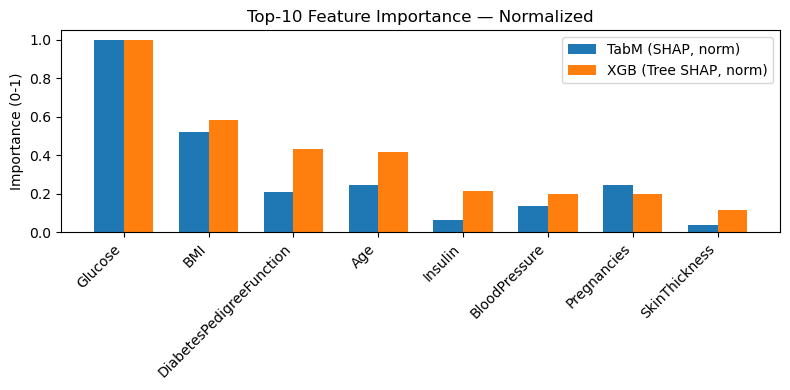

In [ ]:

"""
TabM vs XGBoost :  Accuracy --&-- Feature-Importance (SHAP) Comparison
"""

import os, warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt, shap
warnings.filterwarnings("ignore", category=UserWarning)
os.environ["CUDA_VISIBLE_DEVICES"] = ""          # only CPU

from sklearn.model_selection  import train_test_split
from sklearn.preprocessing    import StandardScaler
from sklearn.metrics          import accuracy_score
from xgboost                  import XGBClassifier

import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from tabm_reference import Model                   

# ----------  Config ----------
CSV      = "diabetes.csv"
SEED     = 42
TEST_R   = 0.2
BATCH    = 64
EPOCHS   = 20
LR       = 1e-3
DEV      = torch.device("cpu")


df          = pd.read_csv(CSV)
features    = df.columns.drop("Outcome").tolist()
X, y        = df[features].values, df["Outcome"].values

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=TEST_R, random_state=SEED, stratify=y
)
scaler      = StandardScaler().fit(X_tr)
X_tr, X_te  = scaler.transform(X_tr), scaler.transform(X_te)

# ---------- TabM ----------
torch.manual_seed(SEED);  np.random.seed(SEED)
tabm = Model(
    n_num_features=len(features), cat_cardinalities=[],
    n_classes=2,
    backbone={"type":"MLP","n_blocks":2,"d_block":64,"dropout":0.1},
    arch_type="tabm", k=8,
    bins=None, num_embeddings=None, share_training_batches=True
).to(DEV)

loss_fn = nn.CrossEntropyLoss()
opt     = torch.optim.Adam(tabm.parameters(), lr=LR)

loader = DataLoader(
    TensorDataset(torch.tensor(X_tr, dtype=torch.float32),
                  torch.tensor(y_tr, dtype=torch.long)),
    batch_size=BATCH, shuffle=True
)
tabm.train()
for _ in range(EPOCHS):
    for xb, yb in loader:
        xb, yb = xb.to(DEV), yb.to(DEV)
        opt.zero_grad()
        logits = tabm(x_num=xb).mean(1)
        loss_fn(logits, yb).backward();  opt.step()

tabm.eval()
with torch.no_grad():
    logits = tabm(x_num=torch.tensor(X_te, dtype=torch.float32).to(DEV)).mean(1)
    pred_tm = logits.argmax(1).cpu().numpy()
acc_tabm = accuracy_score(y_te, pred_tm)
print(f"[✓] TabM  accuracy : {acc_tabm:.4f}")

# ---------- XGBoost ----------
xgb = XGBClassifier(eval_metric="logloss", random_state=SEED)
xgb.fit(X_tr, y_tr)
pred_xgb = xgb.predict(X_te)
acc_xgb  = accuracy_score(y_te, pred_xgb)
print(f"[✓] XGBoost accuracy: {acc_xgb:.4f}")

# ---------- SHAP ----------
## 5.1 XGB TreeExplainer
sv_xgb = shap.TreeExplainer(xgb).shap_values(X_te)
sv_xgb = sv_xgb[1] if isinstance(sv_xgb, (list, tuple)) else sv_xgb   # →(n,feat)
imp_xgb = np.abs(sv_xgb).mean(0)                                      # (feat,)

## 5.2 TabM Explainer  
def prob_pos(mat: np.ndarray) -> np.ndarray:
    with torch.no_grad():
        t = torch.tensor(mat, dtype=torch.float32).to(DEV)
        p = torch.softmax(tabm(x_num=t).mean(1), 1)[:, 1]
    return p.cpu().numpy()

bg          = shap.sample(X_tr, 50, random_state=SEED)
sv_tabm_all = shap.Explainer(prob_pos, bg, feature_names=features)(X_te[:200]).values

if sv_tabm_all.ndim == 3:                      
    sv_tabm_all = sv_tabm_all[:, 0, :]         
imp_tabm = np.abs(sv_tabm_all).mean(0)          

assert imp_xgb.shape[0] == imp_tabm.shape[0] == len(features)


# ① importance / max，to 0~1
imp_xgb_n  = imp_xgb  / imp_xgb.max()
imp_tabm_n = imp_tabm / imp_tabm.max()

df_imp = (pd.DataFrame({
            "feature":features,
            "XGB_norm":    imp_xgb_n,
            "TabM_norm":   imp_tabm_n})
          .sort_values("XGB_norm", ascending=False)
          .reset_index(drop=True))

print("\n=== Normalized Feature Importance (0-1) ===")
print(df_imp.to_string(index=False))

# ------- Plot -------
topn  = min(10, len(features))
df_tp = df_imp.head(topn)
x     = np.arange(topn);  w = .35

plt.figure(figsize=(8,4))
plt.bar(x-w/2, df_tp["TabM_norm"], w, label="TabM (SHAP, norm)")
plt.bar(x+w/2, df_tp["XGB_norm"],  w, label="XGB (Tree SHAP, norm)")
plt.xticks(x, df_tp["feature"], rotation=45, ha="right")
plt.ylim(0,1.05); plt.ylabel("Importance (0-1)")
plt.title("Top-10 Feature Importance — Normalized")
plt.legend(); plt.tight_layout()
plt.savefig("feat_importance_norm.png", dpi=300)
plt.show()
